# Measuring mass resolution

In this notebook I'll attempt to determine the mass resolution by fitting a resonance of known width with a Voigt profile.  The Voigt profile has two width parameters: one accounting for the width of the resonance (as in the Cauchy distribution), and another accounting for detector mass measurement resolution (a Gaussian).  This will first be carried out on simulation first.

In [242]:
%cd '/home/naodell/work/CMS/amumu'
%matplotlib inline

import sys, os

import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
from lmfit import Parameters

from nllfitter import Model, NLLFitter
import nllfitter.fit_tools as ft
import nllfitter.plot_tools as pt


/home/naodell/work/CMS/amumu


### Get the data
The simulated dataset has a b' decaying to a b quark and a mystery boson which subsequently decays to two muons.  The FWHM of the b' was set to be ?? GeV.  Let's get our mass spectra,

In [243]:
xlim = (100, 250) # restrict consideration to data the lies in this range
ntuple_dir = 'data/flatuples/mumu_2012'
data = pd.read_pickle('data/flatuples/mumu_2012/ntuple_bprime_xb.pkl')
data = data.query('{0[0]} < dilepton_b_mass < {0[1]}'.format(xlim))
mass = data.dilepton_b_mass.values

### Define the fit function
The Voigt profile inherits the property of the the Cauchy distribution that it does not normalize on the range $(-\infty, \infty)$.  To address this, I will integrate over the fit range.

(Based on inspection of the mass spectrum I believe this parameterization is insufficient.  A possible way of dealing with this is allowing the width of the Gaussian to vary as a function of the mass.)

In [244]:
def pdf(x, a):
    a = list(a)
    f = lambda z: ft.voigt(z, np.concatenate((a[:2], [a[2] + a[3]*z])))
    if isinstance(x, np.ndarray):
        fx = np.array([f(xx) for xx in x])
    else:
        fx = f(x)
    norm = integrate.quad(f, xlim[0], xlim[1])[0]
    
    return fx/norm

### Set up and carry out fit

In [245]:
params = Parameters()
params.add_many(
                ('mu'     , 175. , True  , 165., 185. , None),
                ('gamma'  , 2.  , False , 5.  , 15.  , None),
                ('sigma0' , 5.   , True  , 1.  , 50.  , None),
                ('sigma1' , 0.1  , True  , -5.  , 5.  , None)
               )
model = Model(pdf, params)
fitter = NLLFitter(model)
result = fitter.fit(mass, calculate_corr=True)

Fit finished with status: 0
[[Variables]]
    mu:       170.853972 +/- 0.159666 (0.09%) (init= 175)
    gamma:    5 (fixed)
    sigma0:   38.2602231 +/- 0.914177 (2.39%) (init= 5)
    sigma1:  -0.14272401 +/- 0.005750 (4.03%) (init= 0.1)

[[Correlation matrix]]
[[ 1.     0.197  0.672 -0.681]
 [ 0.197  1.     0.262 -0.391]
 [ 0.672  0.262  1.    -0.984]
 [-0.681 -0.391 -0.984  1.   ]] 



When I ran this I got values of $\sigma_{0}$ and $\sigma_{1}$ of 38.7 and -0.16, respectively.  From these values, the $\mu\mu+b$ mass resolution at ~175 GeV can be estimated to be,

In [246]:
print result.x[2] + 175*result.x[3]

13.2835199007


### Make some plots

First, let's inspect the mass spectrum and determine visually how well the fit performs.

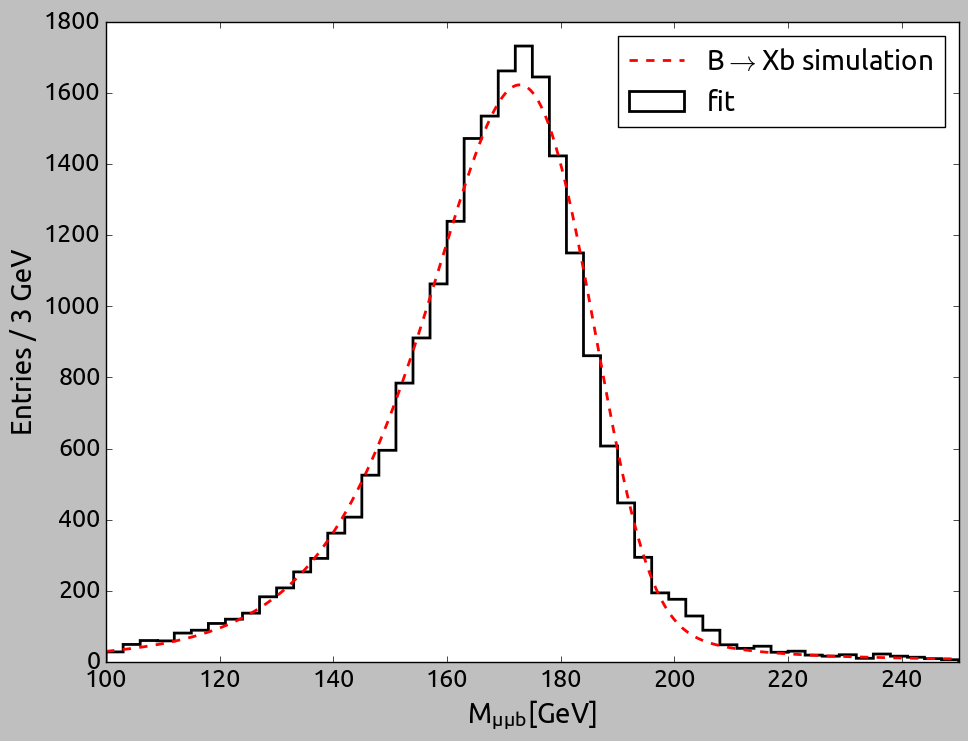

In [249]:
pt.set_new_tdr()
plt.hist(mass, bins=50, range=(100, 250), histtype='step', linewidth=2., color='k')

x = np.linspace(xlim[0], xlim[1], 10000)
y = mass.size*(xlim[1] - xlim[0])*pdf(x, result.x)/50
plt.plot(x, y, 'r--', linewidth=2.)

plt.legend([r'$\sf B\rightarrow Xb$ simulation', 'fit'])
plt.xlim(100, 250)
plt.xlabel('$\sf M_{\mu\mu b} [GeV]$')
plt.ylabel('Entries / 3 GeV')
plt.show()

Looks quite good!  Now let's look at the mass resolution as a function of some of the relevant features.  First, the resolution versus $M_{\mu\mu b}$,

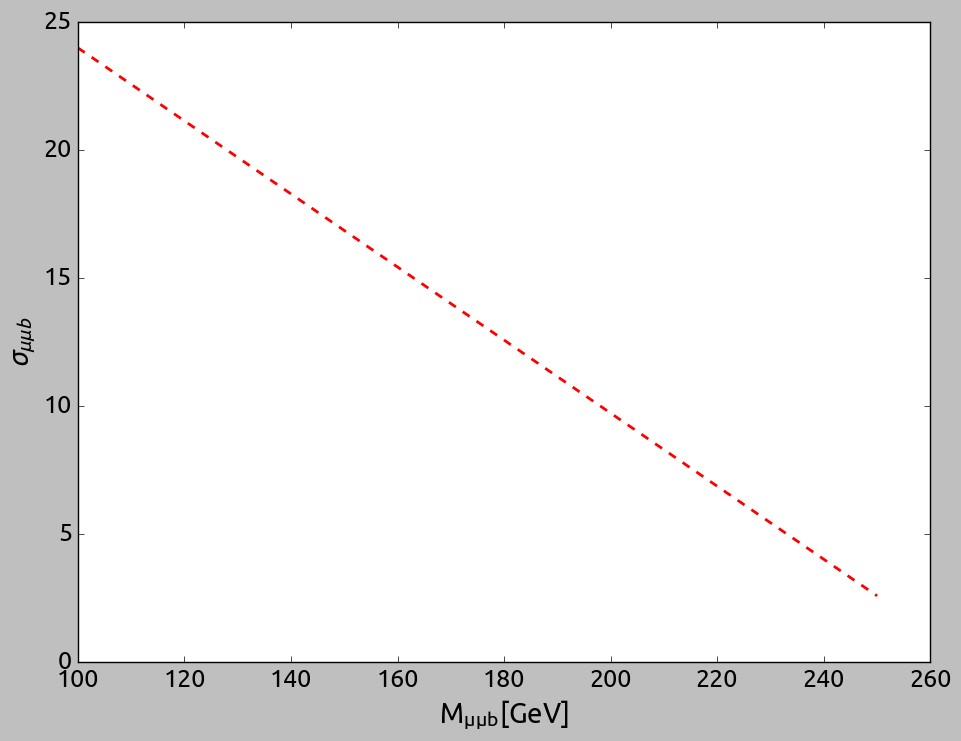

In [248]:
y = result.x[2] + x*result.x[3]
plt.plot(x, y, 'r--', linewidth=2.)
plt.xlabel('$\sf M_{\mu\mu b} [GeV]$')
plt.ylabel('$\sigma_{\mu\mu b}$')
plt.show()

It is clear that this is probably not an accurate depiction of the actual dependence of the resolution as a function of mass.  A few more polynomial terms would likely reveal a more fitting functional form.  Or it might make sense to parameterize sigma as a function of the $p_{T}$ of three particles used to calculate the mass.  It can also be the case that the lower mass side is contaminated with events where the b jet does not correspond to the b quark from b' decay.